# Goal

Understand which measurements are most common in ICU data.

In [1]:
# Load duckdb, which lets us efficiently load large files
import duckdb

# Load pandas, which lets us manipulate dataframes
import pandas as pd

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Set configrations on jupysql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connect jupysql to DuckDB using a SQLAlchemy-style connection string. Either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///:memory:

In [2]:
import duckdb
import pandas as pd

con = duckdb.connect(':memory:')

tables = ['caregiver', 'chartevents', 'd_items', 'datetimeevents', 'icustays', 'ingredientevents', 'inputevents']

def get_table_stats(table):
    columns = con.execute(f"SELECT * FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/{table}.parquet') LIMIT 0").df().columns
    query = f"""
    SELECT 
        '{table}' AS table_name,
        COUNT(*) AS total_rows,
        {f"COUNT(DISTINCT subject_id) AS unique_subjects," if 'subject_id' in columns else "NULL AS unique_subjects,"}
        {f"COUNT(DISTINCT hadm_id) AS unique_hospitalizations" if 'hadm_id' in columns else "NULL AS unique_hospitalizations"}
    FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/{table}.parquet')
    """
    return con.execute(query).fetchdf()

results = pd.concat([get_table_stats(table) for table in tables])
print(results.to_string(index=False))

      table_name  total_rows  unique_subjects  unique_hospitalizations
       caregiver       17984              NaN                      NaN
     chartevents   432997491          65366.0                  85242.0
         d_items        4095              NaN                      NaN
  datetimeevents     9979761          65097.0                  84804.0
        icustays       94458          65366.0                  85242.0
ingredientevents    14253480          58616.0                  76369.0
     inputevents    10953713          58696.0                  76510.0


In [3]:
%%sql 

WITH all_events AS (
    SELECT itemid, 'chartevents' AS event_type FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/chartevents.parquet')
    UNION ALL
    SELECT itemid, 'datetimeevents' AS event_type FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/datetimeevents.parquet')
    UNION ALL
    SELECT itemid, 'ingredientevents' AS event_type FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/ingredientevents.parquet')
    UNION ALL
    SELECT itemid, 'inputevents' AS event_type FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/inputevents.parquet')
)
SELECT 
    d.itemid,
    d.label,
    COUNT(*) AS total_events,
    COUNT(DISTINCT ae.event_type) AS event_types
FROM 
    read_parquet('~/data/physionet.org/processed/mimiciv/icu/d_items.parquet') d
JOIN 
    all_events ae ON d.itemid = ae.itemid
GROUP BY 
    d.itemid, d.label
ORDER BY 
    total_events DESC
LIMIT 50;

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,itemid,label,total_events,event_types
0,227969,Safety Measures,12869833,1
1,220045,Heart Rate,8752069,1
2,220210,Respiratory Rate,8636655,1
3,220277,O2 saturation pulseoxymetry,8567015,1
4,220048,Heart Rhythm,7947289,1
5,224650,Ectopy Type 1,7049295,1
6,220490,Water,5904795,1
7,220179,Non Invasive Blood Pressure systolic,5378740,1
8,220180,Non Invasive Blood Pressure diastolic,5377689,1
9,220181,Non Invasive Blood Pressure mean,5372922,1


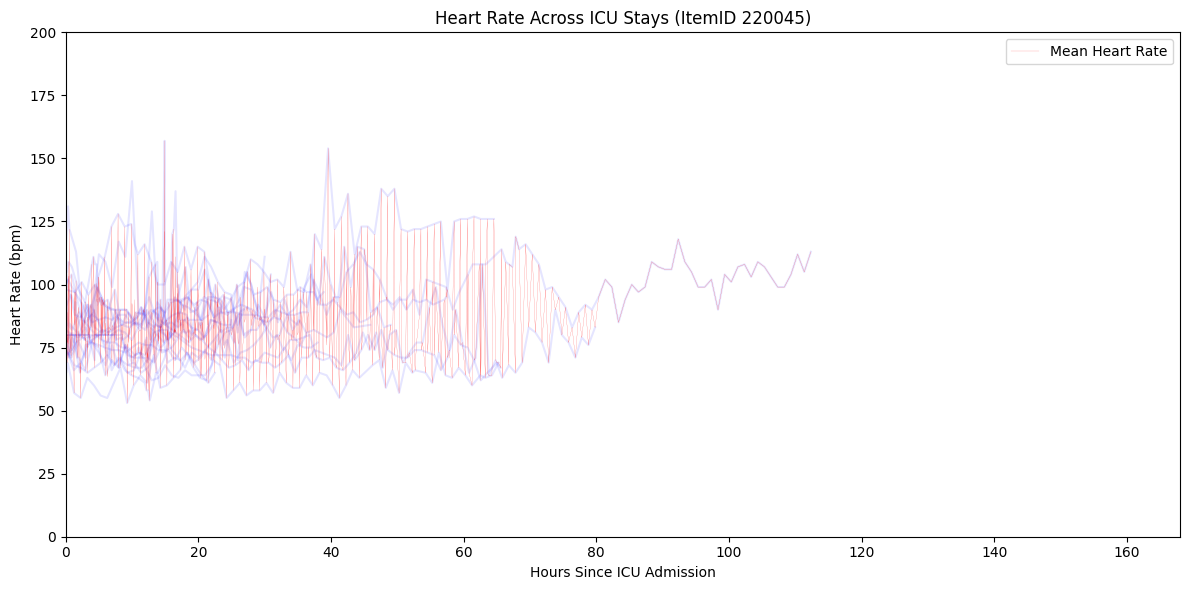

Total number of ICU stays: 21
Total number of heart rate measurements: 1000
Mean heart rate: 85.67 bpm
Median heart rate: 84.00 bpm


In [9]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Connect to DuckDB
con = duckdb.connect(':memory:')

# Query to get heart rate data
query = """
SELECT 
    stay_id,
    CAST(charttime AS TIMESTAMP) AS charttime,
    CAST(valuenum AS FLOAT) AS heart_rate
FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/chartevents.parquet')
WHERE itemid = 220045 AND valuenum > 0 AND valuenum < 300
ORDER BY stay_id, charttime
LIMIT 1000;
"""

# Execute query and load results into a pandas DataFrame
df = con.execute(query).df()

# Convert charttime to datetime
df['charttime'] = pd.to_datetime(df['charttime'])

# Calculate time since ICU admission for each stay
df['hours_since_admission'] = df.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot heart rate for each stay
for stay in df['stay_id'].unique():
    stay_data = df[df['stay_id'] == stay]
    plt.plot(stay_data['hours_since_admission'], stay_data['heart_rate'], alpha=0.1, color='blue')

# Calculate and plot the mean heart rate
mean_hr = df.groupby('hours_since_admission')['heart_rate'].mean()
plt.plot(mean_hr.index, mean_hr.values, color='red', linewidth=0.1, label='Mean Heart Rate')

plt.title('Heart Rate Across ICU Stays (ItemID 220045)')
plt.xlabel('Hours Since ICU Admission')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.ylim(0, 200)  # Adjust y-axis limits for better visibility
plt.xlim(0, 168)  # Show up to 7 days (168 hours)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total number of ICU stays: {df['stay_id'].nunique()}")
print(f"Total number of heart rate measurements: {len(df)}")
print(f"Mean heart rate: {df['heart_rate'].mean():.2f} bpm")
print(f"Median heart rate: {df['heart_rate'].median():.2f} bpm")

In [11]:
%%sql

COPY (
    SELECT 
        subject_id,
        stay_id,
        charttime,
        valuenum AS heart_rate
    FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/chartevents.parquet')
    WHERE itemid = 220045 AND valuenum > 0 AND valuenum < 300
    ORDER BY subject_id, stay_id, charttime
) TO '~/data/physionet.org/figures/heart_rate_data.parquet' (FORMAT PARQUET);

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [12]:
%%sql

WITH heart_rate_data AS (
    SELECT 
        subject_id,
        stay_id,
        charttime,
        heart_rate
    FROM read_parquet('~/data/physionet.org/figures/heart_rate_data.parquet')
),
icustays AS (
    SELECT 
        subject_id,
        stay_id,
        hadm_id
    FROM read_parquet('~/data/physionet.org/processed/mimiciv/icu/icustays.parquet')
),
drgcodes AS (
    SELECT 
        subject_id,
        hadm_id,
        drg_type,
        drg_code
    FROM read_parquet('~/data/physionet.org/processed/mimiciv/hosp/drgcodes.parquet')
    WHERE drg_type = 'HCFA'
),
ms_drg_to_mdc AS (
    SELECT
        ms_drg,
        mdc
    FROM read_parquet('~/data/physionet.org/processed/mimiciv/hosp/ms_drg_to_mdc.parquet')
)
SELECT 
    h.subject_id,
    h.stay_id,
    h.charttime,
    h.heart_rate,
    m.mdc
FROM 
    heart_rate_data h
JOIN 
    icustays i ON h.stay_id = i.stay_id
JOIN 
    drgcodes d ON i.subject_id = d.subject_id AND i.hadm_id = d.hadm_id
LEFT JOIN
    ms_drg_to_mdc m ON CAST(d.drg_code AS INTEGER) = m.ms_drg
WHERE
    m.mdc IS NOT NULL
ORDER BY 
    h.subject_id, h.stay_id, h.charttime;

,subject_id,stay_id,charttime,heart_rate,mdc
0,10000032,39553978,2180-07-23 14:12:00,91.0,5
1,10000032,39553978,2180-07-23 14:30:00,93.0,5
2,10000032,39553978,2180-07-23 15:00:00,94.0,5
3,10000032,39553978,2180-07-23 16:00:00,105.0,5
4,10000032,39553978,2180-07-23 17:00:00,97.0,5
...,...,...,...,...,...
6827870,19999987,36195440,2145-11-04 14:00:00,92.0,1
6827871,19999987,36195440,2145-11-04 16:00:00,98.0,1
6827872,19999987,36195440,2145-11-04 19:00:00,93.0,1
6827873,19999987,36195440,2145-11-04 20:00:00,92.0,1



Statistics:
Total number of measurements: 6827875
Number of unique patients: 60302
Number of unique ICU stays: 84972
Number of unique MDCs: 24

Mean heart rate by MDC:
mdc
22    95.400000
14    92.204444
17    91.721503
25    91.239938
12    91.131650
13    90.768993
24    90.395251
7     90.307199
18    90.103615
16    89.554593
6     88.342540
8     88.226995
20    88.204802
4     87.593815
23    87.580824
21    86.040600
9     85.737724
10    85.514214
11    85.408270
5     83.711739
19    82.006982
3     80.223159
1     80.150637
2     78.096330
Name: heart_rate, dtype: float64


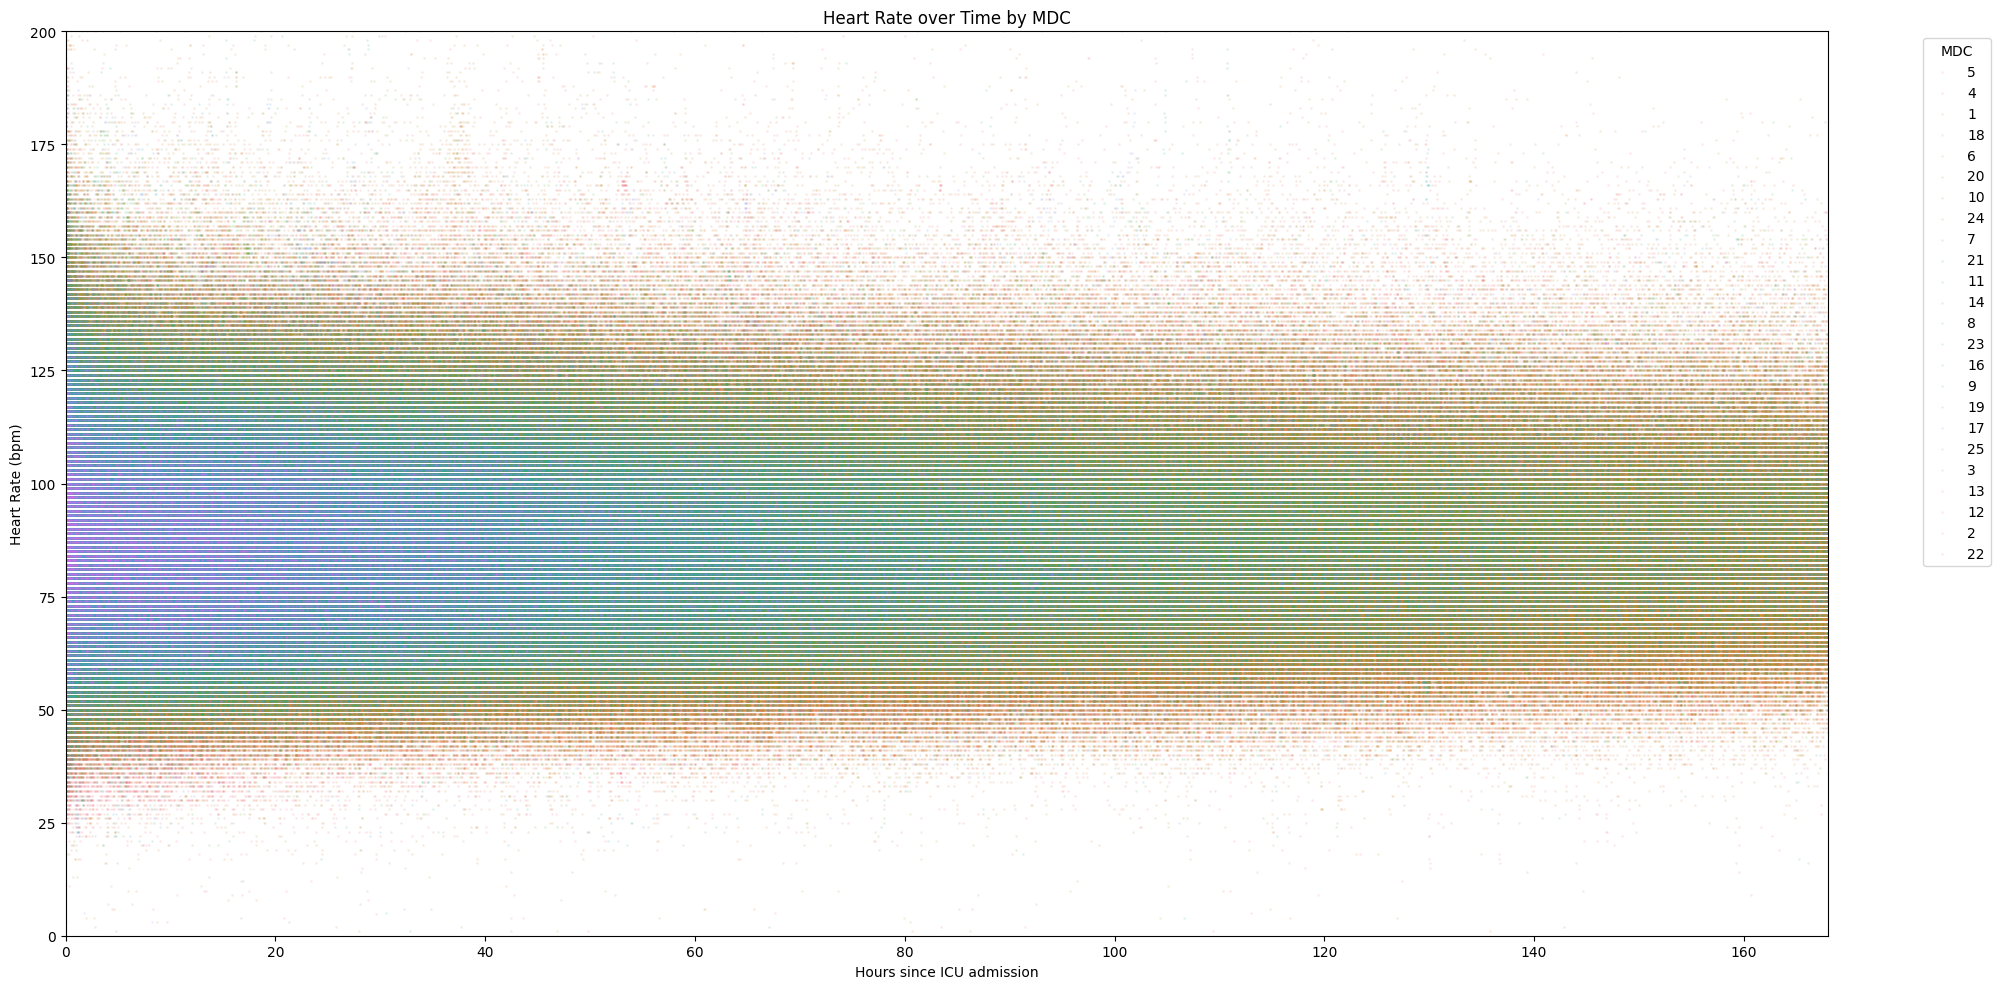

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Read the parquet file
df = pd.read_parquet('~/data/physionet.org/figures/heart_rate.parquet')

# Convert charttime to datetime
df['charttime'] = pd.to_datetime(df['charttime'])

# Calculate hours since first measurement for each stay
df['hours'] = df.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

# Get unique MDCs and assign colors
mdcs = df['mdc'].unique()
n_colors = len(mdcs)
color_palette = sns.color_palette("husl", n_colors=n_colors)
color_map = dict(zip(mdcs, color_palette))

# Create the plot
plt.figure(figsize=(20, 10))

for mdc in mdcs:
    mdc_data = df[df['mdc'] == mdc]
    plt.scatter(mdc_data['hours'], mdc_data['heart_rate'], 
                c=[color_map[mdc]], alpha=0.1, s=1, label=mdc)

plt.xlabel('Hours since ICU admission')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate over Time by MDC')
plt.legend(title='MDC', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 200)
plt.xlim(0, 168)  # First week of ICU stay

plt.tight_layout()

# Calculate and print some statistics
print("\nStatistics:")
print(f"Total number of measurements: {len(df)}")
print(f"Number of unique patients: {df['subject_id'].nunique()}")
print(f"Number of unique ICU stays: {df['stay_id'].nunique()}")
print(f"Number of unique MDCs: {df['mdc'].nunique()}")
print("\nMean heart rate by MDC:")
print(df.groupby('mdc')['heart_rate'].mean().sort_values(ascending=False))

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Read the parquet file
df = pd.read_parquet('~/data/physionet.org/figures/heart_rate.parquet')

# Convert charttime to datetime
df['charttime'] = pd.to_datetime(df['charttime'])

# Calculate hours since first measurement for each stay
df['hours'] = df.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

# Get unique MDCs
mdcs = df['mdc'].unique()

# Create output directory if it doesn't exist
output_dir = '~/data/physionet.org/figures/heart_rate_mdc_plots'
os.makedirs(output_dir, exist_ok=True)

# Create a plot for each MDC
for mdc in mdcs:
    mdc_data = df[df['mdc'] == mdc]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(mdc_data['hours'], mdc_data['heart_rate'], 
                alpha=0.1, s=1, color='blue')
    
    plt.xlabel('Hours since ICU admission')
    plt.ylabel('Heart Rate (bpm)')
    plt.title(f'Heart Rate over Time for MDC {mdc}')
    plt.ylim(0, 200)
    plt.xlim(0, 168)  # First week of ICU stay
    
    # Add mean heart rate line
    mean_hr = mdc_data.groupby('hours')['heart_rate'].mean()
    plt.plot(mean_hr.index, mean_hr.values, color='red', linewidth=2, label='Mean Heart Rate')
    
    plt.legend()
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'{output_dir}/heart_rate_mdc_{mdc}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Calculate and print statistics
print("\nStatistics:")
print(f"Total number of measurements: {len(df)}")
print(f"Number of unique patients: {df['subject_id'].nunique()}")
print(f"Number of unique ICU stays: {df['stay_id'].nunique()}")
print(f"Number of unique MDCs: {df['mdc'].nunique()}")
print("\nMean heart rate by MDC:")
print(df.groupby('mdc')['heart_rate'].mean().sort_values(ascending=False))

print(f"\nPlots saved in {output_dir}")

/var/folders/2c/hmpw9qgd7fd3x0ms6548_f880000gn/T/ipykernel_39935/2063665322.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/2c/hmpw9qgd7fd3x0ms6548_f880000gn/T/ipykernel_39935/2063665322.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{output_dir}/heart_rate_mdc_{mdc}.png', dpi=300, bbox_inches='tight')



Statistics:
Total number of measurements: 6827875
Number of unique patients: 60302
Number of unique ICU stays: 84972
Number of unique MDCs: 24

Mean heart rate by MDC:
mdc
22    95.400000
14    92.204444
17    91.721503
25    91.239938
12    91.131650
13    90.768993
24    90.395251
7     90.307199
18    90.103615
16    89.554593
6     88.342540
8     88.226995
20    88.204802
4     87.593815
23    87.580824
21    86.040600
9     85.737724
10    85.514214
11    85.408270
5     83.711739
19    82.006982
3     80.223159
1     80.150637
2     78.096330
Name: heart_rate, dtype: float64

Plots saved in ~/data/physionet.org/figures/heart_rate_mdc_plots


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the parquet file
df = pd.read_parquet('~/data/physionet.org/figures/heart_rate.parquet')

# Create the plot
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create the box plot
sns.boxplot(x='mdc', y='heart_rate', data=df, palette='viridis')

# Customize the plot
plt.title('Heart Rate Distribution by Major Diagnostic Category (MDC)', fontsize=16)
plt.xlabel('Major Diagnostic Category (MDC)', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add median values on top of each box
medians = df.groupby('mdc')['heart_rate'].median().round(1)
for i, median in enumerate(medians):
    plt.text(i, median, f'{median}', ha='center', va='bottom', fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.savefig('~/data/physionet.org/figures/heart_rate_boxplot_by_mdc.png', dpi=300, bbox_inches='tight')
plt.close()

# Print some statistics
print("\nStatistics:")
print(f"Total number of measurements: {len(df)}")
print(f"Number of unique patients: {df['subject_id'].nunique()}")
print(f"Number of unique ICU stays: {df['stay_id'].nunique()}")
print(f"Number of unique MDCs: {df['mdc'].nunique()}")

print("\nMedian heart rate by MDC:")
print(medians.sort_values(ascending=False))

print("\nPlot saved as ~/data/physionet.org/figures/heart_rate_boxplot_by_mdc.png")

/var/folders/2c/hmpw9qgd7fd3x0ms6548_f880000gn/T/ipykernel_54165/1936410681.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mdc', y='heart_rate', data=df, palette='viridis')



Statistics:
Total number of measurements: 6827875
Number of unique patients: 60302
Number of unique ICU stays: 84972
Number of unique MDCs: 24

Median heart rate by MDC:
mdc
22    93.0
14    91.0
13    90.0
24    90.0
17    90.0
25    90.0
7     89.0
12    89.0
18    89.0
16    88.0
6     87.0
8     87.0
20    87.0
4     86.0
21    85.0
9     85.0
23    85.0
10    84.0
11    84.0
5     82.0
19    81.0
3     79.0
1     79.0
2     77.0
Name: heart_rate, dtype: float64

Plot saved as ~/data/physionet.org/figures/heart_rate_boxplot_by_mdc.png


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the parquet file
df = pd.read_parquet('~/data/physionet.org/figures/heart_rate.parquet')

# Convert charttime to datetime
df['charttime'] = pd.to_datetime(df['charttime'])

# Sort the dataframe
df = df.sort_values(['subject_id', 'stay_id', 'charttime'])

# Calculate RR intervals (in seconds)
df['RR'] = df.groupby(['subject_id', 'stay_id'])['charttime'].diff().dt.total_seconds()

# Function to calculate SDNN
def calculate_sdnn(group):
    return np.std(group['RR'].dropna())

# Calculate SDNN for each stay
hrv = df.groupby(['subject_id', 'stay_id', 'mdc']).apply(calculate_sdnn).reset_index()
hrv.columns = ['subject_id', 'stay_id', 'mdc', 'sdnn']

# Create the plot
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create the box plot
sns.boxplot(x='mdc', y='sdnn', data=hrv, palette='viridis')

# Customize the plot
plt.title('Heart Rate Variability (SDNN) by Major Diagnostic Category (MDC)', fontsize=16)
plt.xlabel('Major Diagnostic Category (MDC)', fontsize=12)
plt.ylabel('SDNN (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add median values on top of each box
medians = hrv.groupby('mdc')['sdnn'].median().round(3)
for i, median in enumerate(medians):
    plt.text(i, median, f'{median}', ha='center', va='bottom', fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.savefig('~/data/physionet.org/figures/hrv_boxplot_by_mdc.png', dpi=300, bbox_inches='tight')
plt.close()

# Print some statistics
print("\nHeart Rate Variability (SDNN) Statistics:")
print(f"Total number of ICU stays analyzed: {len(hrv)}")
print(f"Number of unique patients: {hrv['subject_id'].nunique()}")
print(f"Number of unique MDCs: {hrv['mdc'].nunique()}")

print("\nMedian SDNN by MDC (in seconds):")
print(medians.sort_values(ascending=False))

print("\nPlot saved as ~/data/physionet.org/figures/hrv_boxplot_by_mdc.png")

# Save HRV data to parquet
hrv.to_parquet('~/data/physionet.org/figures/heart_rate_variability.parquet')
print("\nHRV data saved to ~/data/physionet.org/figures/heart_rate_variability.parquet")

/var/folders/2c/hmpw9qgd7fd3x0ms6548_f880000gn/T/ipykernel_54165/1084294524.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hrv = df.groupby(['subject_id', 'stay_id', 'mdc']).apply(calculate_sdnn).reset_index()
/var/folders/2c/hmpw9qgd7fd3x0ms6548_f880000gn/T/ipykernel_54165/1084294524.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mdc', y='sdnn', data=hrv, palette='viridis')



Heart Rate Variability (SDNN) Statistics:
Total number of ICU stays analyzed: 84972
Number of unique patients: 60302
Number of unique MDCs: 24

Median SDNN by MDC (in seconds):
mdc
1     1200.087
22    1105.138
5     1078.503
24    1075.150
14    1050.398
13    1035.430
6     1025.092
2     1024.869
23    1023.516
17    1015.519
8     1011.598
19     977.128
12     976.098
7      946.362
16     914.792
18     914.203
9      883.001
11     879.899
21     855.148
25     847.394
20     810.816
3      803.161
4      795.852
10     791.025
Name: sdnn, dtype: float64

Plot saved as ~/data/physionet.org/figures/hrv_boxplot_by_mdc.png

HRV data saved to ~/data/physionet.org/figures/heart_rate_variability.parquet
